# Testing procedure for 1D pendulum

In [356]:
import numpy as np
from numpy import random as rnd
from numpy.linalg import pinv
from numpy import linalg as lg
from scipy import linalg as slg
from importlib import reload
import seaborn as snb
import matplotlib.pyplot as plt
import Utils.Functions 
from Utils.Functions import *
import pbdlib as pbd
from scipy.linalg import hankel
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 3
np.set_printoptions(precision=5, suppress=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create training and testing signals

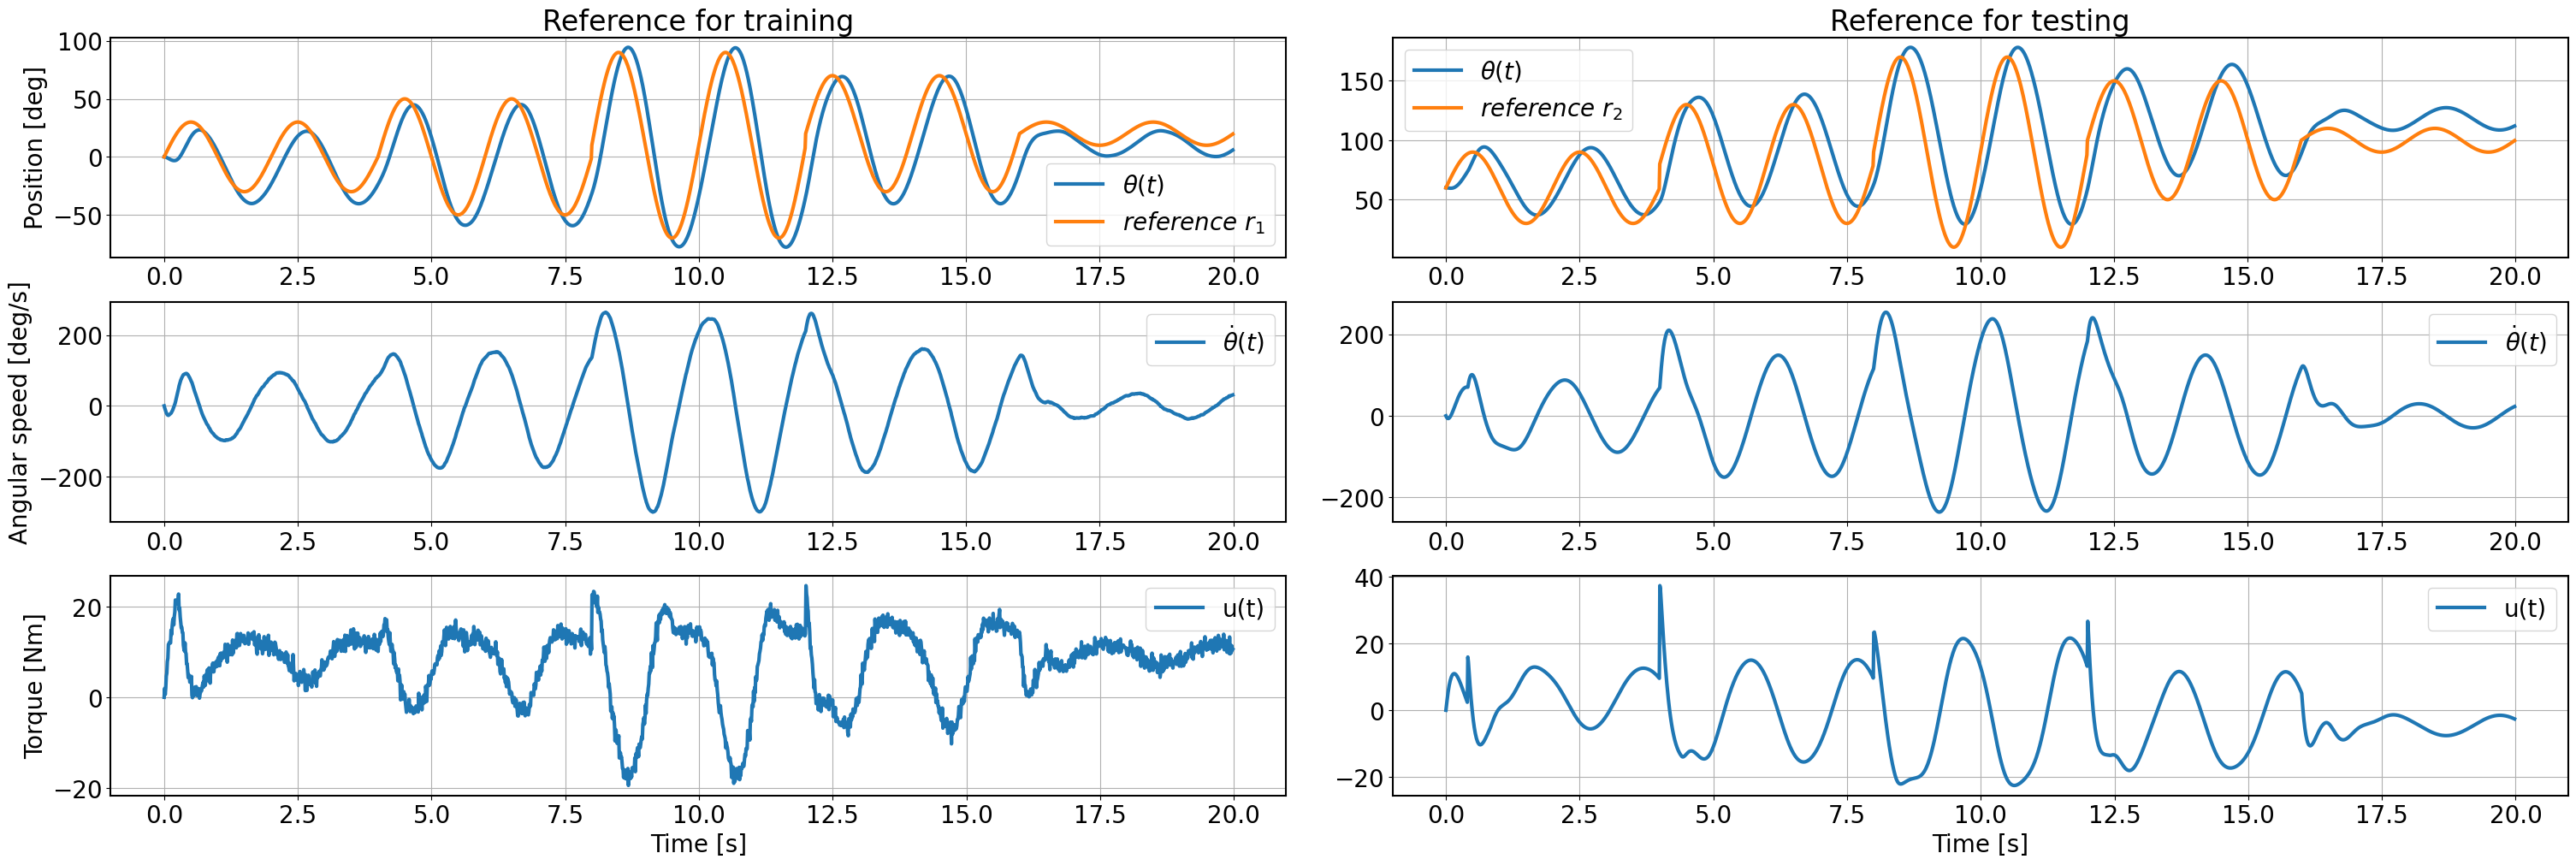

In [578]:
# Varying sinusoids ###################################################
# Pendulum instance
dt = 1e-2

# Controller design
K, Ki, Kd, t_max = 10, 50, 0, 12

# Varying sine
ref1 = varSine([30,50,80,50,10], [.5,.5,.5,.5,.5], 2*np.array([1,1,1,1,1]), [0,0,10,20,20], dt)
ref2 = varSine([30,50,80,50,10], [.5,.5,.5,.5,.5], 2*np.array([1,1,1,1,1]), [60,80,90,100,100], dt)

time = np.arange(0,len(ref1)*dt,dt)
pend1 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(0),0]), dt=dt)
pend2 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(60),0]), dt=dt)
pend1.ref, pend2.ref = ref1, ref2

for i in range(pend1.N-1):
    if i <= pend1.N:
        Kp, Ki, Kd = 50, 20, 5
    else:
        Kp, Ki, Kd = 10, 2.5, 5
    pend1.U[i] = PID(pend1.X, i, pend1.ref[i], Kp, Kd, Ki, pend1.dt, 20, limit=200, integral=integral)[0] + rnd.normal(0,1,1)
    pend1.X[:,i+1] = RK4(pend1.dynamics, pend1.X[:,i], pend1.U[i], pend1.dt, type='controller-step-by-step')
    pend2.U[i] = PID(pend2.X, i, pend2.ref[i], 60, 11, 25, pend2.dt, 40, limit=200)[0]
    pend2.X[:,i+1] = RK4(pend2.dynamics, pend2.X[:,i], pend2.U[i], pend2.dt, type='controller-step-by-step')

# Simple sinusoids ###################################################    
# time = np.arangge(0,20,dt)
# pend1 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(-90),0]), dt=dt)
# pend2 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(0),0]), dt=dt)
# # Reference design
# freq1, freq2 = .125, .125
# pend1.T_ref, pend2.T_ref = 1/freq1/pend1.dt, 1/freq2/pend2.dt
# amplitude1, amplitude2 = 40, 50 # deg
# pend1.ref = sineReference(pend1.N, pend1.dt, pend1.T_ref, amplitude1, 70)
# # pend1.ref = sineReference(pend1.N, pend1.dt, [], [], offset=60, varying=True, freq_vector=[.4], amp_vector=[30])
# # pend1.ref, precision = squareReference(pend1.N, pend1.T_ref, [deg2rad(20),deg2rad(-90)], np.int(pend1.T_ref), 0)
# pend2.ref = sineReference(pend2.N, pend1.dt, pend2.T_ref, amplitude2, 120)
# # pend2.ref, precision = squareReference(pend1.N, pend1.T_ref, [deg2rad(100),deg2rad(0)], np.int(pend1.T_ref), 0)
# u1 = lambda i: 5 + 2.5*np.sin(2*np.pi/pend1.T_ref*i)
# u2 = lambda i: 5 + 1.5*np.cos(2*np.pi/pend2.T_ref*i)

# # Simulation

# integral = 0
# for i in range(pend1.N-1):
#     if i <= pend1.N:
#         Kp, Ki, Kd = 20, 5, 35
#     else:
#         Kp, Ki, Kd = 10, 2.5, 5
#     pend1.U[i] = PID(pend1.X, i, pend1.ref[i], Kp, Kd, Ki, pend1.dt, 80, limit=200, integral=integral)[0]
#     pend1.X[:,i+1] = RK4(pend1.dynamics, pend1.X[:,i], pend1.U[i], pend1.dt, type='controller-step-by-step')
#     pend2.U[i] = PID(pend2.X, i, pend2.ref[i], 50, 11, 25, pend2.dt, 40, limit=200)[0]
#     pend2.X[:,i+1] = RK4(pend2.dynamics, pend2.X[:,i], pend2.U[i], pend2.dt, type='controller-step-by-step')
    
# Plots
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(3, 2, 
                       constrained_layout = True, figsize=(30,10))

ax[0,0].plot(pend1.T, rad2deg(pend1.X[0,:]), label=r"$\theta (t)$")
ax[0,0].plot(pend1.T, rad2deg(np.array(pend1.ref)), label=r"$reference \ r_1$")
ax[0,1].plot(pend2.T, rad2deg(pend2.X[0,:]), label=r"$\theta (t)$")
ax[0,1].plot(pend2.T, rad2deg(np.array(pend2.ref)), label=r"$reference \ r_2$")
ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid(), ax[0,1].grid()
ax[0,0].legend(), ax[0,1].legend()
ax[0,0].set_title('Reference for training'), ax[0,1].set_title('Reference for testing')

ax[1,0].plot(pend1.T, rad2deg(pend1.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1,1].plot(pend2.T, rad2deg(pend2.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1,0].set_ylabel('Angular speed [deg/s]')
ax[1,0].grid(), ax[1,1].grid()
ax[1,0].legend(), ax[1,1].legend()

ax[2,0].plot(pend1.T[:pend1.N-1], pend1.U, label='u(t)')
ax[2,1].plot(pend2.T[:pend1.N-1], pend2.U, label='u(t)')
ax[2,0].set_xlabel('Time [s]'), ax[2,0].set_ylabel('Torque [Nm]'), ax[2,1].set_xlabel('Time [s]')
ax[2,0].grid(), ax[2,1].grid()
ax[2,0].legend(), ax[2,1].legend()

fig.savefig('Images/Pend_id_sineVar.svg',format='svg',dpi=800)

Text(0.5, 1.0, 'Singular values of the Hankel matrix SVD')

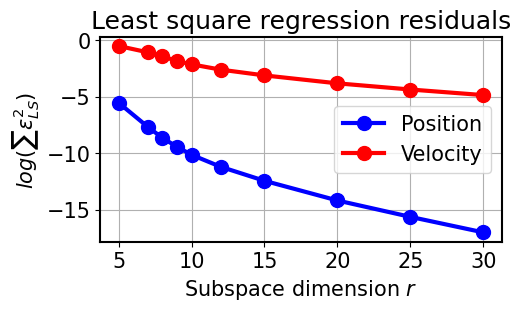

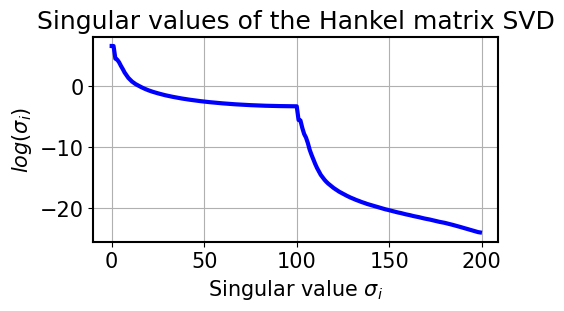

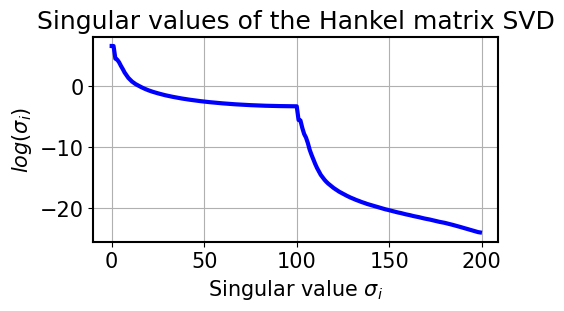

In [455]:
# In the following, pend1 --> training of A & B
#                   pend2 --> testing (trajectory simulation)

pend = pend1
# horizon = np.int(len(pend.T)*.6)
horizon = 100
model1 = HAVOK(pend.X, pend1.U)
X0 = [deg2rad(60),0]

nb_delay = [5,7,8,9,10,12,15,20,25,30]
nb_plots = len(nb_delay)
res = np.empty(shape=[2,nb_plots])

# plt.rcParams['font.size'] = 15
# fig, ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

pend = pend2

# ax[0,0].plot(pend.T, rad2deg(pend.X[0,:]), label=r"$\theta (t)$")
# ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
# ax[0,0].grid()

# ax[0,1].plot(pend.T, rad2deg(pend.X[1,:]), label=r"$\dot{\theta} (t)$")
# ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg]')
# ax[0,1].grid()

# ax[1,0].plot(pend.T[:len(pend.T)-1], pend.U, label='Input')
# ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
# ax[1,0].grid(), ax[1,0].legend(), ax[1,0].set_title('Original control input')

for i in range(nb_plots):
    tau = nb_delay[i]
    model1.HANKEL(horizon)
    model1.SVD(tau)
    model1.LS(tau)
    model1.Simulate(pend.X0, U_testing=pend.U)
    
    
#     ax[0,0].plot(pend.T[:len(pend.T)], rad2deg(model1.X_traj[0,:]), label='r = '+str(tau))
#     ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
#     ax[0,0].grid()
#     ax[0,0].legend(bbox_to_anchor=(.9, 1.3),ncol=nb_plots,fontsize=12)

#     ax[0,1].plot(pend.T[:len(pend.T)], rad2deg(model1.X_traj[1,:]), label='r = '+str(tau))
#     ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
#     ax[0,1].grid()
#     ax[0,1].legend(bbox_to_anchor=(.9, 1.35),ncol=nb_plots,fontsize=12)
    
    res[:,i] = model1.residuals
    
# ax[1,1].plot(nb_delay, np.log(res[0,:]),'-o', markersize=10, color='b', label='Position')
# ax[1,1].plot(nb_delay, np.log(res[1,:]),'-o', markersize=10, color='r', label='Velocity')
# ax[1,1].set_xlabel(r'Subspace dimension $r$'), ax[1,1].set_ylabel('Log(precision)'), ax[1,1].legend()
# ax[1,1].grid(), ax[1,1].set_title('Least square log residuals')
# ax[0,0].grid(), ax[0,1].grid()

plt.rcParams['font.size'] = 15
fig = plt.figure(constrained_layout = True, figsize=(5,3))
plt.plot(nb_delay, np.log(res[0,:]),'-o', markersize=10, color='b', label='Position')
plt.plot(nb_delay, np.log(res[1,:]),'-o', markersize=10, color='r', label='Velocity')
plt.xlabel(r'Subspace dimension $r$'), plt.ylabel(r'$log(\sum \epsilon_{LS}^2)$'), plt.legend(), plt.grid()
plt.title('Least square regression residuals')

fig.savefig('Images/Pend_DMD_sineVar.svg',format='svg',dpi=800)

plt.rcParams['font.size'] = 15
fig = plt.figure(constrained_layout = True, figsize=(5,3))
plt.plot(np.log(model1.sigma), markersize=10, color='b')
plt.xlabel(r'Singular value $\sigma_i$'), plt.ylabel(r'$log(\sigma_i)$'), plt.grid()
plt.title('Singular values of the Hankel matrix SVD')

plt.rcParams['font.size'] = 15
fig = plt.figure(constrained_layout = True, figsize=(5,3))
plt.plot(np.log(model1.sigma), markersize=10, color='b')
plt.xlabel(r'Singular value $\sigma_i$'), plt.ylabel(r'$log(\sigma_i)$'), plt.grid()
plt.title('Singular values of the Hankel matrix SVD')

692.9690879375768


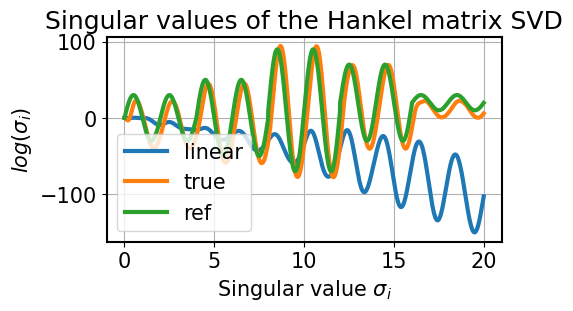

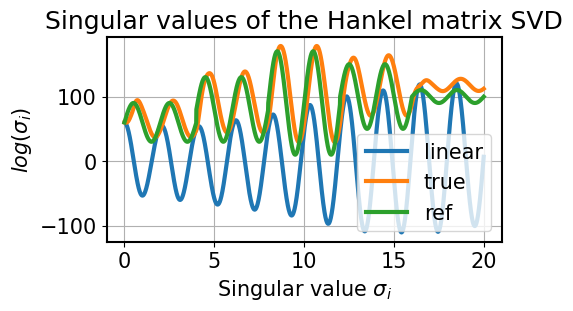

In [583]:
tau = 5
# Training
pend=pend1
model1 = HAVOK(pend.X, pend.U)
# horizon = np.int(len(pend.T)*.7)
horizon = 100
model1.HANKEL(horizon)
model1.SVD(tau)
model1.LS(tau)
model1.Simulate(pend.X0, U_testing=pend.U)

plt.rcParams['font.size'] = 15
fig = plt.figure(constrained_layout = True, figsize=(5,3))
plt.plot(pend.T,rad2deg(model1.X_traj[0,:]), markersize=10, label='linear')
plt.plot(pend.T,rad2deg(pend.X[0,:]), markersize=10, label='true')
plt.plot(pend.T,rad2deg(np.array(pend.ref)), markersize=10, label='ref')
plt.xlabel(r'Singular value $\sigma_i$'), plt.ylabel(r'$log(\sigma_i)$'), plt.grid()
plt.title('Singular values of the Hankel matrix SVD')
plt.legend()

# Testing
pend=pend2
model1.Simulate(pend.X0, U_testing=pend.U)

plt.rcParams['font.size'] = 15
fig = plt.figure(constrained_layout = True, figsize=(5,3))
plt.plot(pend.T,rad2deg(model1.X_traj[0,:]), markersize=10, label='linear')
plt.plot(pend.T,rad2deg(pend.X[0,:]), markersize=10, label='true')
plt.plot(pend.T,rad2deg(np.array(pend.ref)), markersize=10, label='ref')
plt.xlabel(r'Singular value $\sigma_i$'), plt.ylabel(r'$log(\sigma_i)$'), plt.grid()
plt.title('Singular values of the Hankel matrix SVD')
plt.legend()

print(np.amax(model1.s))

## LQR control of learned dynamics
### LQR rollout

[5.16182e-06 1.13223e-08 2.27215e-04 6.59165e-05 3.67243e-03]


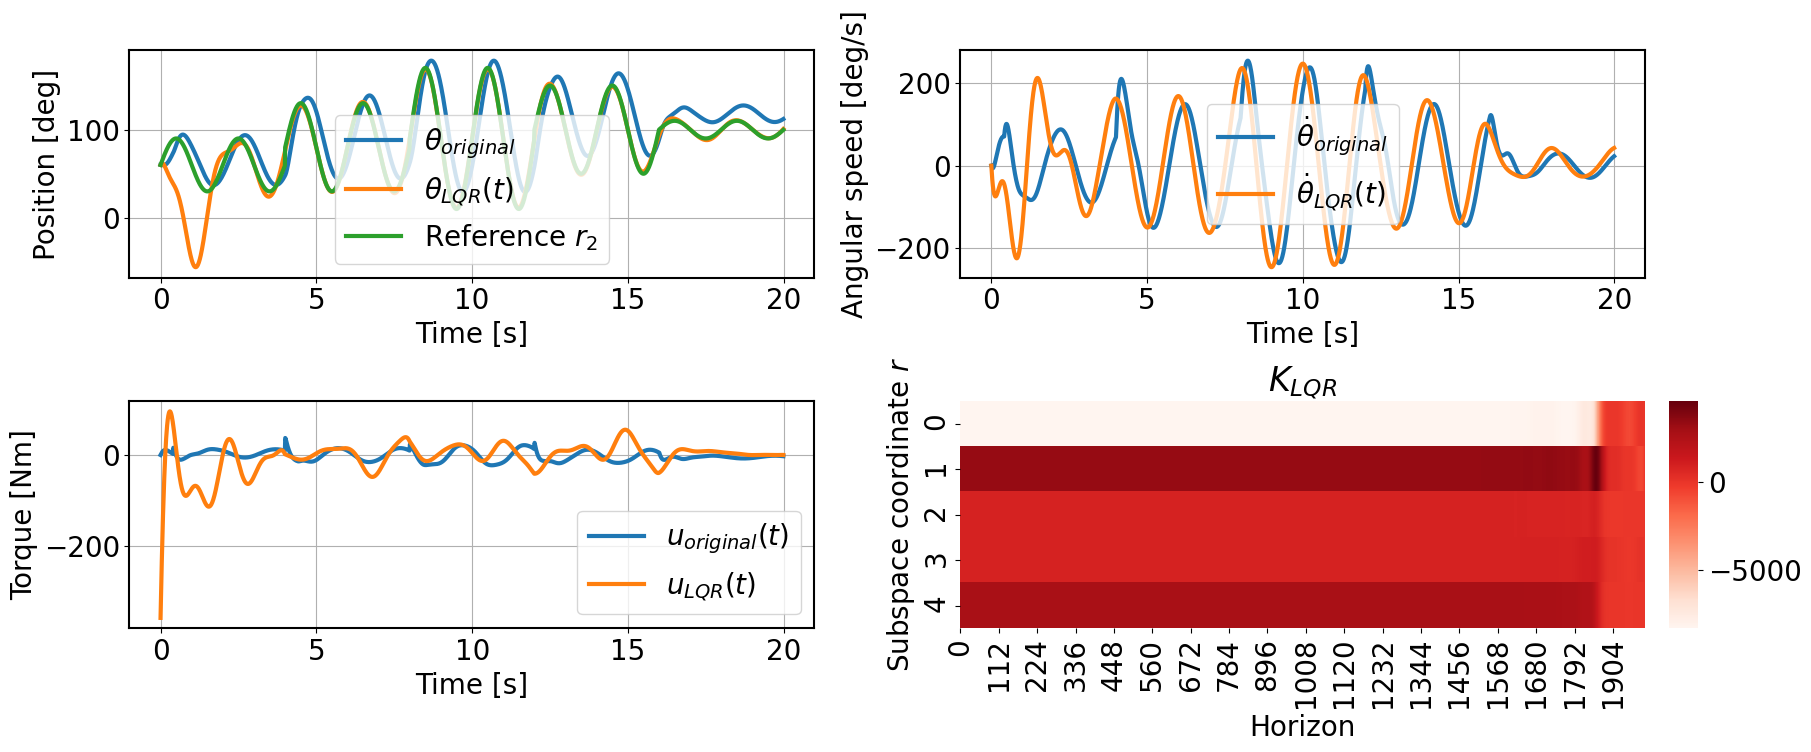

In [565]:
tau = 5
# Training
pend=pend1
model1 = HAVOK(pend.X, pend.U)
# horizon = np.int(len(pend.T)*.7)
horizon = 100
model1.HANKEL(horizon)
model1.SVD(tau)
model1.LS(tau)
# Testing
pend=pend2
model1.Simulate(pend.X0, U_testing=pend.U)
model1.ConstructLQR(x_std=1e6, u_std=1e0, dt=pend.dt, ref=pend.ref)
model1.LQR_simulate(pend.X0)

# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(pend.X[0,:]), label=r'$\theta_{original}$')
ax[0,0].plot(pend.T, rad2deg(model1.LQR_X[:,0]), label=r"$\theta_{LQR} (t)$")
ax[0,0].plot(pend.T, rad2deg(np.array(pend.ref)), label="Reference $r_2$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(pend.X[1,:]), label=r'$\dot{\theta}_{original}$')
ax[0,1].plot(pend.T, rad2deg(model1.LQR_X[:,1]), label=r"$\dot{\theta}_{LQR} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:model1.N-1], pend.U, label='$u_{original}(t)$')
ax[1,0].plot(pend.T[:model1.N-1], model1.LQR_U[0,:,0], label='$u_{LQR}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')

print(model1.C@model1.res)

### LQR planning for true dynamics

LQR cost :  71555480909.42072


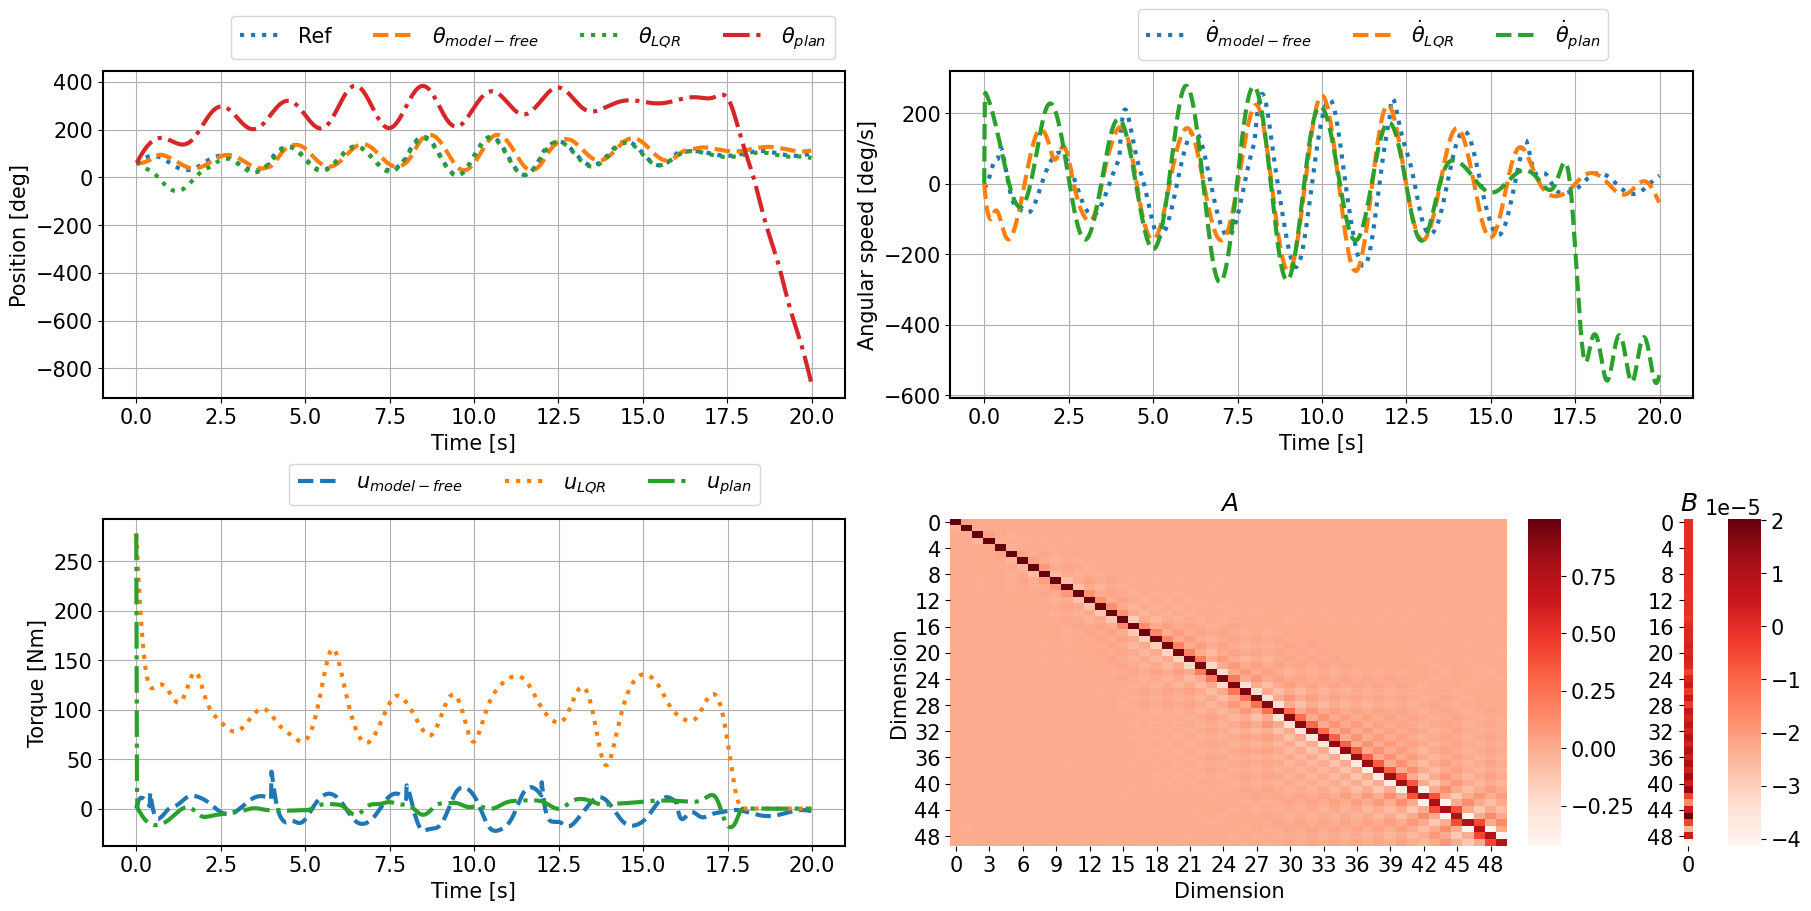

In [557]:
pend = pend2
X0 = pend.X0
Xc, Yc = np.zeros(shape=[model1.nb_S,model1.N]), np.zeros(shape=[model1.tau,model1.N])
Uc = np.empty(shape=[model1.N-1])
Ky = np.array(model1.LQR.K)[:,0,:]
Kx = Ky@pinv(model1.C)
t_interval = pend.dt

# Initial condition
Xc[:,0] = X0
N = np.eye(model1.tau) - pinv(model1.C) @ model1.C
Y0 = pinv(model1.C)@X0
Y0 = Y0 + N@(model1.Y[:,0] - Y0) # Nullspace projection into subspace 
Yc[:,0] = Y0

f = lambda theta, u : pend.dynamics(theta, u)

# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(model1.N-1):
    
    Uc[i] = model1.LQR.get_command(Yc[:,i],i)
    
    Xc[:,i+1]= RK4(f, Xc[:,i], Uc[i], t_interval, type='controller-step-by-step')
    Yc[:,i+1] = pinv(model1.C)@Xc[:,i+1]
    
print('LQR cost : ',model1.LQR_cost(Xc, Uc, pend.ref))
    
# Plot
plt.rcParams['font.size'] = 15
fig = plt.figure(constrained_layout = True, figsize=(18,9))

gs = fig.add_gridspec(8, 8)

ax00 = fig.add_subplot(gs[0:4,0:4])
ax01 = fig.add_subplot(gs[0:4,4:8])
ax10 = fig.add_subplot(gs[4:8,0:4])
ax11_0 = fig.add_subplot(gs[4:8,4:7])
ax11_1 = fig.add_subplot(gs[4:8,7:8])

ax00.plot(pend.T, rad2deg(np.array(pend.ref)), linestyle='dotted', label='Ref')
ax00.plot(pend.T, rad2deg(pend.X[0,:]), linestyle='dashed', label=r'$\theta_{model-free}$')
ax00.plot(pend.T, rad2deg(model1.LQR_X[:,0]), linestyle=':', label=r'$\theta_{LQR}$')
ax00.plot(pend.T, rad2deg(Xc[0,:]), linestyle='dashdot', label=r"$\theta_{plan}$")
ax00.set_xlabel('Time [s]'), ax00.set_ylabel('Position [deg]')
ax00.grid()
ax00.legend(bbox_to_anchor=(1, 1.2),ncol=5)

ax01.plot(pend.T, rad2deg(pend.X[1,:]), linestyle='dotted', label=r'$\dot{\theta}_{model-free}$')
ax01.plot(pend.T, rad2deg(model1.LQR_X[:,1]), linestyle='dashed', label=r"$\dot{\theta}_{LQR}$")
ax01.plot(pend.T, rad2deg(Xc[1,:]), linestyle='dashed', label=r"$\dot{\theta}_{plan}$")
ax01.set_xlabel('Time [s]'), ax01.set_ylabel('Angular speed [deg/s]')
ax01.grid()
ax01.legend(bbox_to_anchor=(.9, 1.22),ncol=4)

ax10.plot(pend.T[:model1.N-1], pend.U, linestyle='dashed', label='$u_{model-free}$')
ax10.plot(pend.T[:model1.N-1], model1.LQR_U[0,:,0], linestyle='dotted', label='$u_{LQR}$')
ax10.plot(pend.T[:model1.N-1], Uc, linestyle='dashdot', label='$u_{plan}$')
ax10.set_xlabel('Time [s]'), ax10.set_ylabel('Torque [Nm]')
ax10.grid()
ax10.legend(bbox_to_anchor=(.9, 1.2),ncol=3)

ax11_0.set_title('$A$')
figA = snb.heatmap(model1.A,cmap='Reds',ax=ax11_0)
ax11_0.set_ylabel('Dimension'), ax11_0.set_xlabel('Dimension')

ax11_1.set_title('$B$')
figA = snb.heatmap(model1.B,cmap='Reds')

fig.savefig('Images/Pend_HAVOK_trajectories_sineVar.svg',format='svg',dpi=800)

In [210]:
print('LQR cost of LQR : ',model1.LQR_cost(Xc, Uc, pend.ref))
print('xQx = ',model1.xQx), print('uRu = ',model1.uRu)
print('LQR cost of MFC : ',model1.LQR_cost(pend.X, pend.U, pend.ref))
print('xQx = ',model1.xQx), print('uRu = ',model1.uRu)
print('ratio = ',model1.LQR_cost(Xc, Uc, pend.ref)/model1.LQR_cost(pend.X, pend.U, pend.ref))

LQR cost of LQR :  28460015754.561054
xQx =  28459920533.111553
uRu =  95221.44949947103
LQR cost of MFC :  34780846471.60255
xQx =  34780402319.09913
uRu =  444152.50342042116
ratio =  0.8182669095704083


## (2) LQR robustness to initial condition variations

In [221]:
ic_variations = np.array([-.25,-.2,-.15,-.1,-.05,-.01,0,.01,.05,.1,.15,.2,.25]) + 1
# ic_variations = np.array([.2]) + 1
X0_original = 120
M = len(ic_variations)
original_cost = np.empty(shape=M)
LQR_cost = np.empty(shape=M)
xQx = np.empty(shape=[2,M])
uRu = np.empty(shape=[2,M])

# Initial condition
Xc, Yc = np.zeros(shape=[model1.nb_S,model1.N]), np.zeros(shape=[model1.tau,model1.N])
N = np.eye(model1.tau) - pinv(model1.C) @ model1.C
f = lambda theta, u : pend.dynamics(theta, u)

for i in range(M):
    # New IC
    pend.X0 = np.array([deg2rad(X0_original*ic_variations[i]),0])
    
    # LQR training
    Xc[:,0] = pend.X0
    Y0 = pinv(model1.C)@X0
    Y0 = Y0 + N@(model1.Y[:,0] - Y0) # Nullspace projection into subspace 
    Yc[:,0] = Y0
    model1.ConstructLQR(x_std=1e6, u_std=5e-1, dt=pend.dt, ref=pend.ref)
    pend.X[:,0] = pend.X0
    
    for j in range(model1.N-1):
    
        # Original simulation
        pend.U[j] = PID(pend.X, j, pend.ref[j], 150, 3, 15, pend.dt, 50, limit=100)[0]
        pend.X[:,j+1] = RK4(pend.dynamics, pend.X[:,j], pend.U[j], pend.dt, type='controller-step-by-step')

        Uc[j] = model1.LQR.get_command(Yc[:,j],j)

        # LQR planning
        Xc[:,j+1]= RK4(f, Xc[:,j], Uc[j], t_interval, type='controller-step-by-step')
        Yc[:,j+1] = pinv(model1.C)@Xc[:,j+1]
    
    # LQR cost saving
    original_cost[i] = model1.LQR_cost(pend.X, pend.U, pend.ref)
    xQx[0,i], uRu[0,i] = model1.xQx, model1.uRu
    LQR_cost[i] = model1.LQR_cost(Xc, Uc, pend.ref)
    xQx[1,i], uRu[1,i] = model1.xQx, model1.uRu
    
print(np.multiply(LQR_cost,np.reciprocal(original_cost)))
print(LQR_cost)
print(original_cost)
print(xQx)
print(uRu)

# plt.figure()
# plt.plot(pend.X[0,:]), plt.plot(Xc[0,:])
# plt.figure()
# plt.plot(pend.U), plt.plot(Uc)

[0.45776 0.42524 0.39187 0.3594  0.32997 0.31016 0.30586 0.30186 0.28897
 0.28038 0.28015 0.28735 0.3004 ]
[9.05178e+09 7.71937e+09 6.60101e+09 5.69660e+09 5.00601e+09 4.60736e+09
 4.52905e+09 4.45927e+09 4.26548e+09 4.21500e+09 4.37730e+09 4.75198e+09
 5.33864e+09]
[1.97741e+10 1.81529e+10 1.68447e+10 1.58503e+10 1.51709e+10 1.48548e+10
 1.48075e+10 1.47728e+10 1.47612e+10 1.50333e+10 1.56249e+10 1.65373e+10
 1.77718e+10]
[[1.97740e+10 1.81528e+10 1.68446e+10 1.58503e+10 1.51709e+10 1.48548e+10
  1.48074e+10 1.47728e+10 1.47612e+10 1.50332e+10 1.56248e+10 1.65372e+10
  1.77716e+10]
 [9.05171e+09 7.71931e+09 6.60095e+09 5.69655e+09 5.00596e+09 4.60731e+09
  4.52900e+09 4.45922e+09 4.26543e+09 4.21495e+09 4.37723e+09 4.75190e+09
  5.33856e+09]]
[[146067.4302  116412.38565  92425.44508  74124.61854  61529.67619
   55576.25136  54661.95697  53977.65563  53544.15355  58200.07497
   68654.38825  84932.34118 107059.46843]
 [ 69729.69886  60940.64662  54470.69763  50318.76326  48481.60034
   

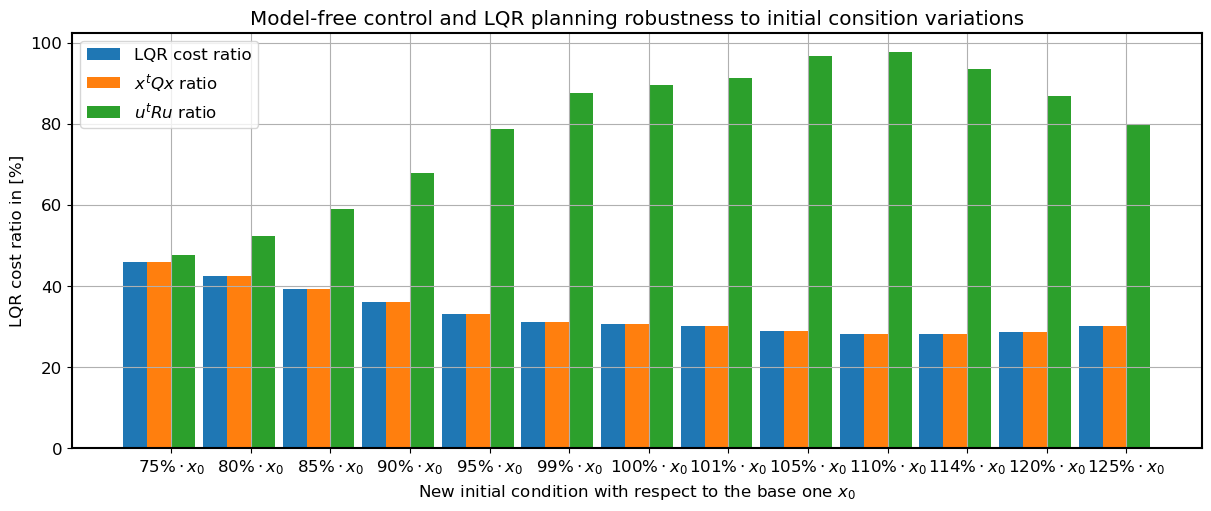

In [223]:
plt.rcParams['font.size'] = 12
x_label = [(str(np.int(x*100))+r'$\%\cdot x_0$') for x in ic_variations.tolist()]
barwidth = .3
bar1 = np.arange(len(ic_variations))
bar2 = [x + barwidth for x in bar1]
bar3 = [x + 2*barwidth for x in bar1]

cost_ratio = np.multiply(LQR_cost,np.reciprocal(original_cost))
xQx_ratio = np.multiply(xQx[1,:],np.reciprocal(xQx[0,:]))
uRu_ratio = np.multiply(uRu[1,:],np.reciprocal(uRu[0,:]))

fig = plt.figure(constrained_layout = True, figsize=(12,5))
plt.bar(bar1,100*cost_ratio,width = barwidth,label='LQR cost ratio')
plt.bar(bar2,100*xQx_ratio,width = barwidth,label=r'$x^tQx$ ratio')
plt.bar(bar3,100*uRu_ratio,width = barwidth,label=r'$u^tRu$ ratio')

plt.xticks([x + 3*barwidth/2 for x in bar1], x_label)
plt.ylabel('LQR cost ratio in [%]'), plt.xlabel('New initial condition with respect to the base one $x_0$')
plt.title('Model-free control and LQR planning robustness to initial consition variations')
plt.legend(), plt.grid()

fig.savefig('Images/Pend_HAVOK_boxplot.svg',format='svg',dpi=800)

## LQR testing with via-points trajectory
### (1) LQR rollout on linear dynamics

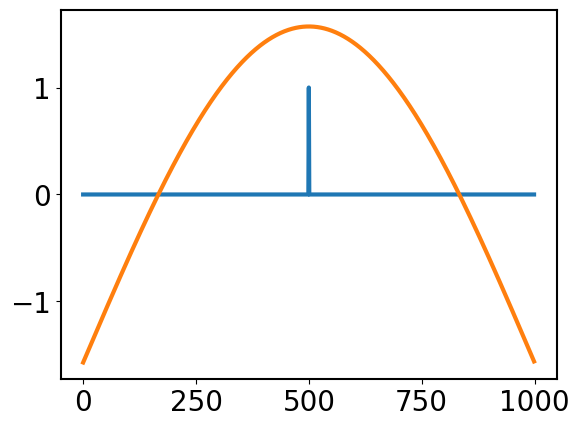

In [323]:
freq = .05
dt = 1e-2
period = 1/freq/dt
pend3 = SimplePendulum(mass=1, length=1, time=np.arange(0,10,dt), X0=np.array([deg2rad(120),0]), dt=dt)
pend = pend3
pend.ref = np.zeros([2,pend.N])
pend.ref[0,:] = sineReference(pend.N, pend.dt, period, 180, -90)
precision = np.zeros(shape=[2,pend.N])
nb = np.int(pend.N/(period/2))

x_std = 1e6
precision[0,np.int(period/4)::np.int(period/2)] = x_std*np.ones(nb)
plt.plot(precision[0,:]/x_std)
plt.plot(pend.ref[0,:])

(Text(0.5, 32.167000000000016, 'Horizon'),
 Text(919.1725803416688, 0.5, 'Subspace coordinate $r$'))

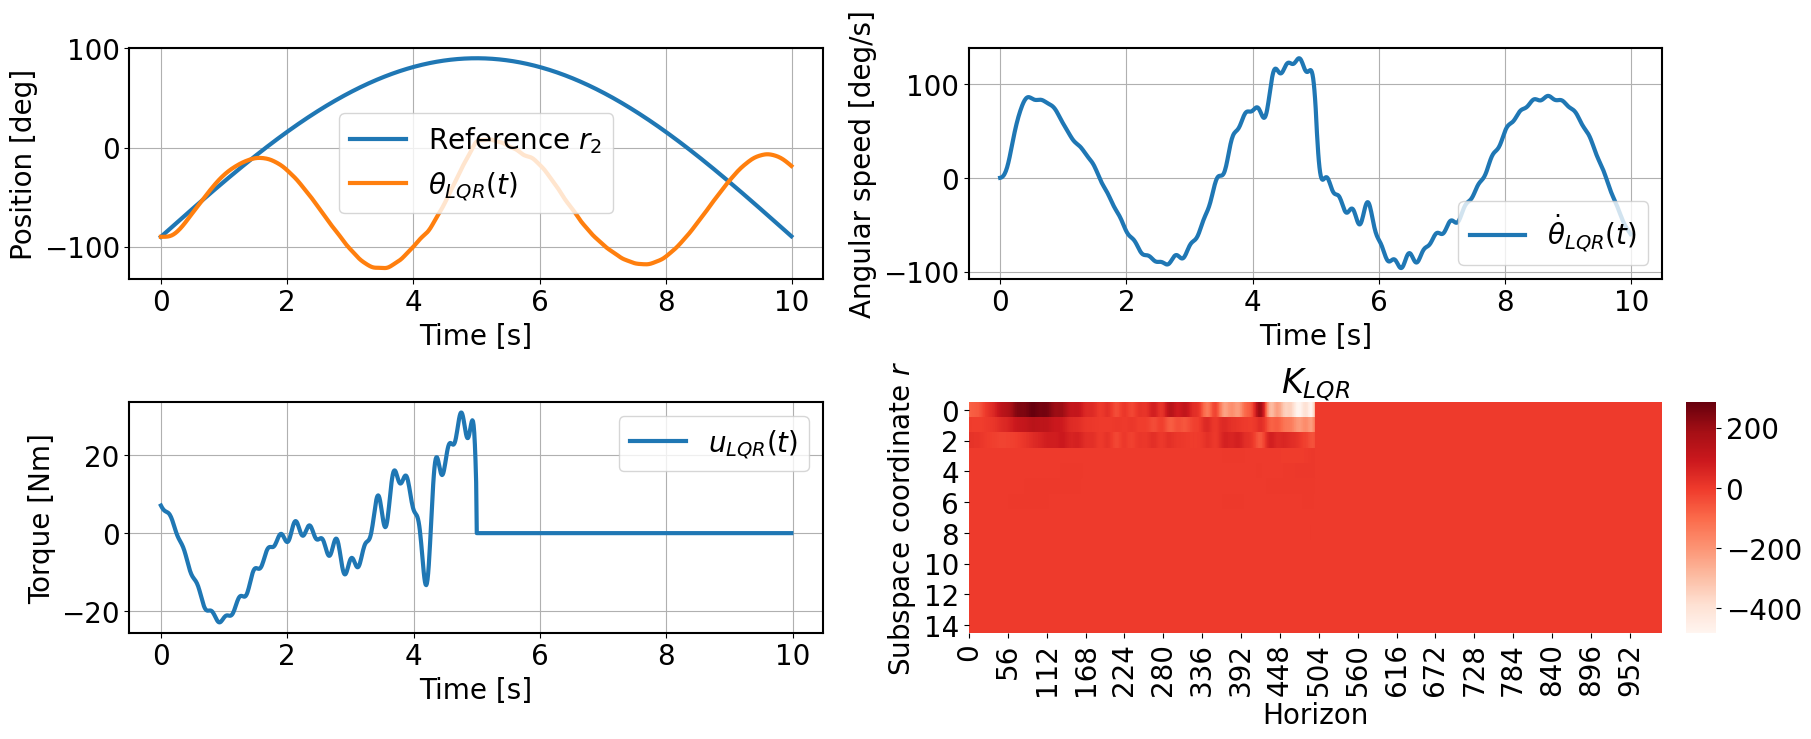

In [325]:
u_std = 1e0
model1.ConstructLQR(x_std=x_std, u_std=u_std, dt=pend.dt, ref=pend.ref.T, custom_trajectory=precision)
model1.LQR_simulate(np.array([deg2rad(-90),0]))

# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(pend.ref[0,:]), label="Reference $r_2$")
ax[0,0].plot(pend.T, rad2deg(model1.LQR_X[:,0]), label=r"$\theta_{LQR} (t)$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(model1.LQR_X[:,1]), label=r"$\dot{\theta}_{LQR} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:model1.N-1], model1.LQR_U[0,:,0], label='$u_{LQR}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')

### (2) LQR trajectory planning

Rollout cost is  127.66883184989427  [%] of planning cost


(Text(0.5, 32.167000000000016, 'Horizon'),
 Text(942.9035844338129, 0.5, 'Subspace coordinate $r$'))

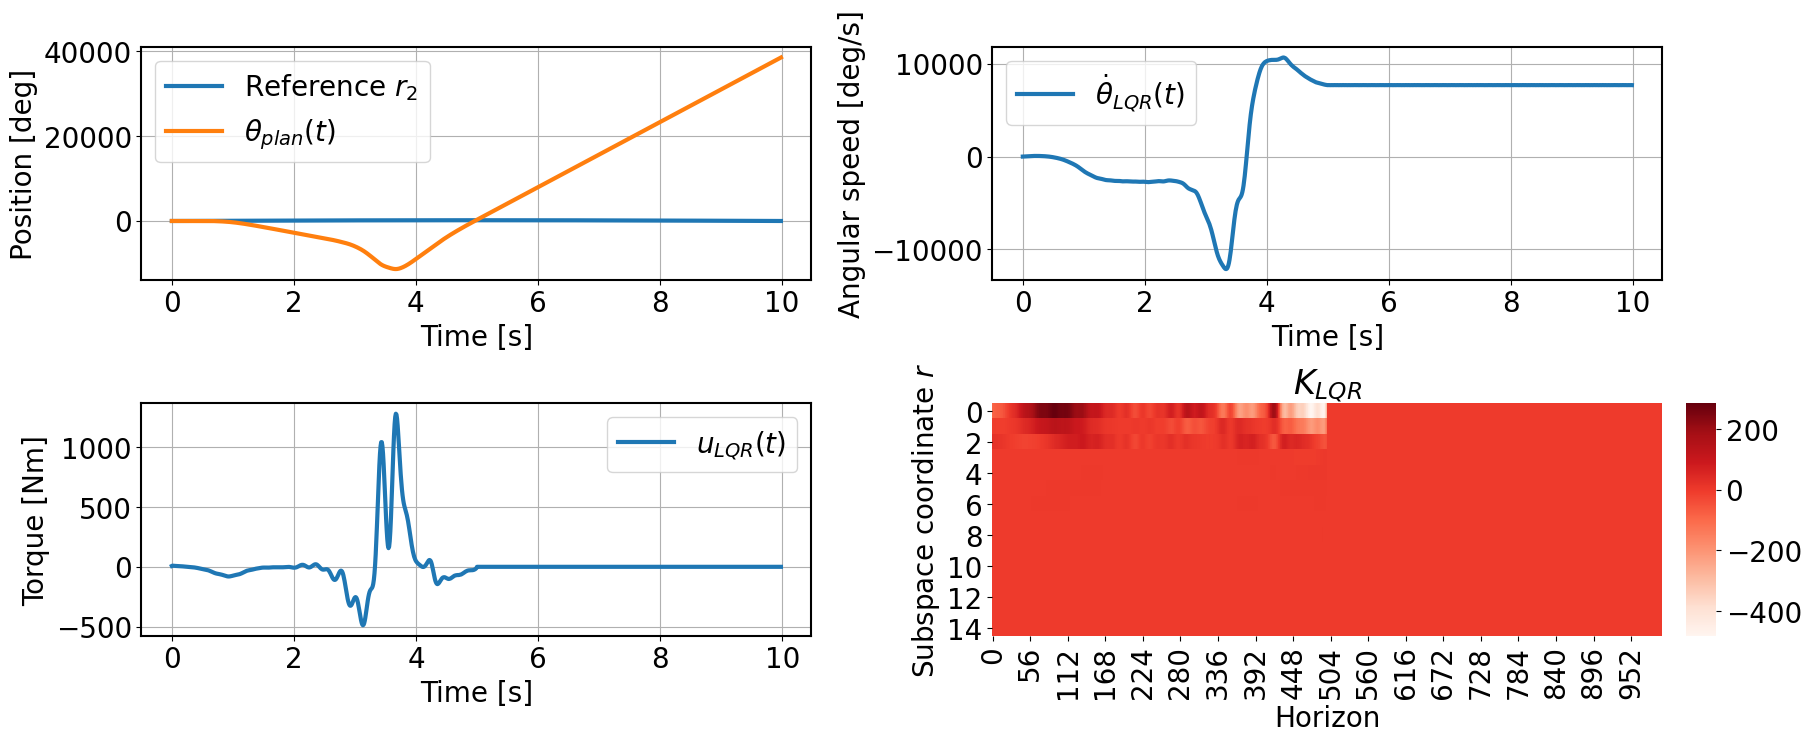

In [326]:
X0 = np.array([deg2rad(-90),0])
Xc, Yc = np.zeros(shape=[model1.nb_S,model1.N]), np.zeros(shape=[model1.tau,model1.N])
Uc = np.empty(shape=[model1.N-1])
Ky = np.array(model1.LQR.K)[:,0,:]
Kx = Ky@pinv(model1.C)
t_interval = pend.dt

# Initial condition
Xc[:,0] = X0
N = np.eye(model1.tau) - pinv(model1.C) @ model1.C
Y0 = pinv(model1.C)@X0
Y0 = Y0 + N@(model1.Y[:,0] - Y0) # Nullspace projection into subspace 
Yc[:,0] = Y0

f = lambda theta, u : pend.dynamics(theta, u)

# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(model1.N-1):
    
    Uc[i] = model1.LQR.get_command(Yc[:,i],i)
    
    Xc[:,i+1]= RK4(f, Xc[:,i], Uc[i], t_interval, type='controller-step-by-step')
    Yc[:,i+1] = pinv(model1.C)@Xc[:,i+1]
    
# Evaluate LQR costs
cost_roll = model1.LQR_cost(model1.LQR_X.T,model1.LQR_U[0,:,0],pend.ref[0,:])
cost_plan = model1.LQR_cost(Xc,Uc,pend.ref[0,:])
print('Rollout cost is ',cost_roll/cost_plan*100,' [%] of planning cost')
    
# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(pend.ref[0,:]), label="Reference $r_2$")
ax[0,0].plot(pend.T, rad2deg(Xc[0,:]), label=r"$\theta_{plan} (t)$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(Xc[1,:]), label=r"$\dot{\theta}_{LQR} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:model1.N-1], Uc, label='$u_{LQR}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')

## Pendulum swing-up using LQR

(Text(0.5, 32.16699999999986, 'Horizon'),
 Text(907.1015701713034, 0.5, 'Subspace coordinate $r$'))

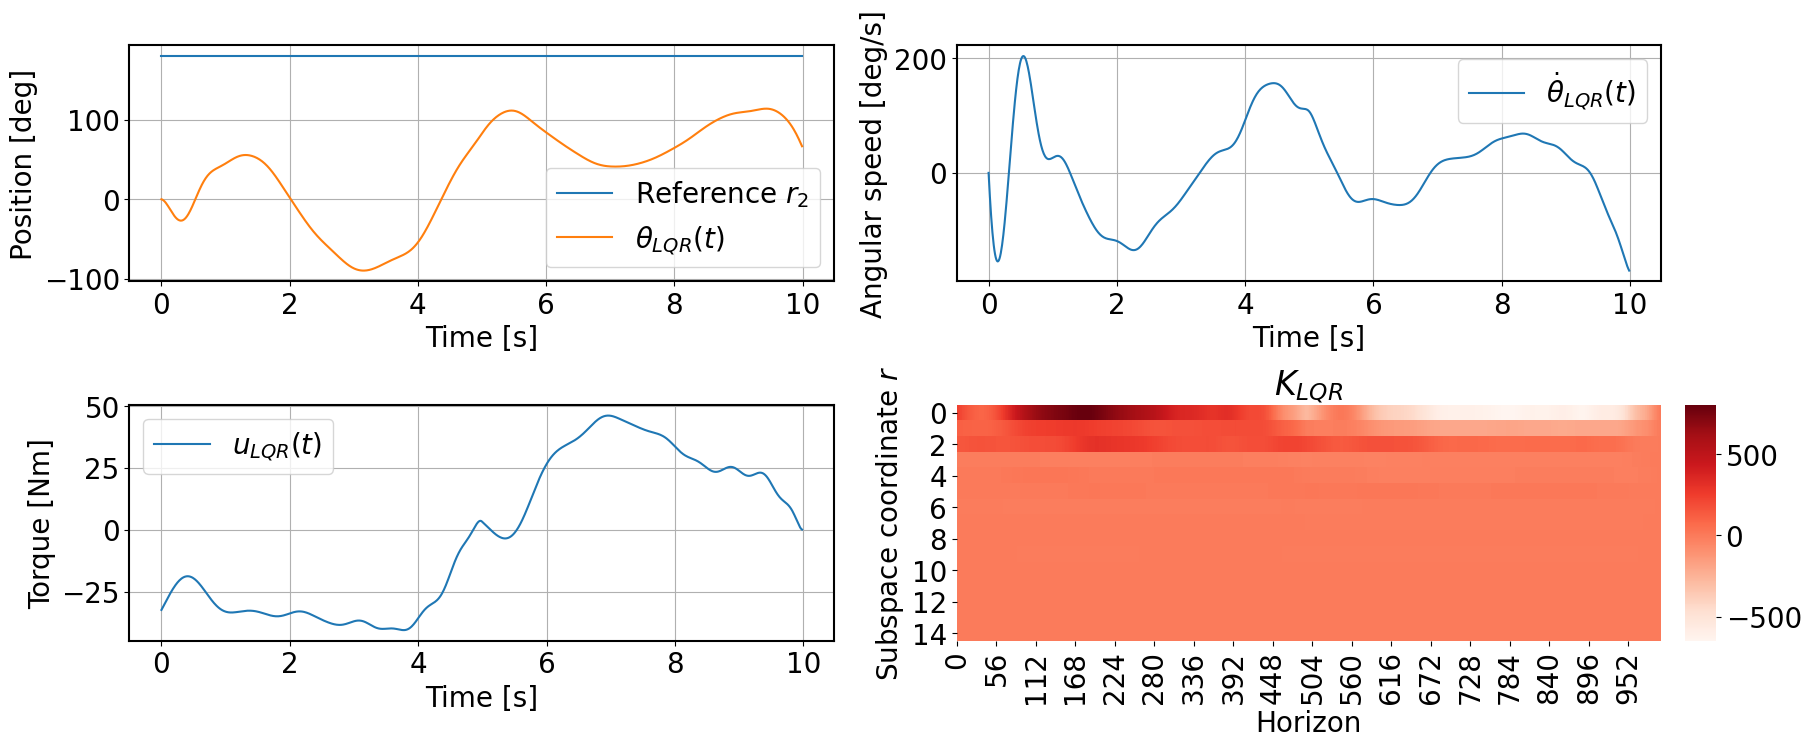

In [53]:
via_points = [deg2rad(180)]
horizon = len(pend.T)
via_time = np.int(horizon/len(via_points))
reference = np.ones(shape=[2,horizon])*via_points[len(via_points)-1]
reference[1,:] = np.zeros(shape=[horizon])
for i in range(len(via_points)-1):
    reference[0,i*via_time:(i+1)*via_time] = np.ones(shape=[via_time])*via_points[i]

precision_dwell = 500 # Number of time-steps with reduced precision
x_std, x_std_dwell, u_std = 1e6, 1e4, 3.
precision = np.ones(shape=[2,horizon])*x_std
precision[1,:] = np.zeros(shape=[horizon]) # Velocity precision
precision_part = np.hstack((np.ones(shape=[precision_dwell])*x_std_dwell,np.ones(shape=[via_time-precision_dwell])*x_std))
for i in range(len(via_points)):
    precision[0,i*via_time:(i+1)*via_time] = precision_part
    
model1.ConstructLQR(x_std=x_std, u_std=u_std, dt=pend.dt, ref=reference.T, custom_trajectory=precision)
model1.LQR_simulate(np.array([0,0]))

# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(reference[0,:]), label="Reference $r_2$")
ax[0,0].plot(pend.T, rad2deg(model1.LQR_X[:,0]), label=r"$\theta_{LQR} (t)$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(model1.LQR_X[:,1]), label=r"$\dot{\theta}_{LQR} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:model1.N-1], model1.LQR_U[0,:,0], label='$u_{LQR}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')

Rollout cost is  3.6040149258617603e-06  [%] of planning cost


(Text(0.5, 32.167000000000016, 'Horizon'),
 Text(919.6744131698881, 0.5, 'Subspace coordinate $r$'))

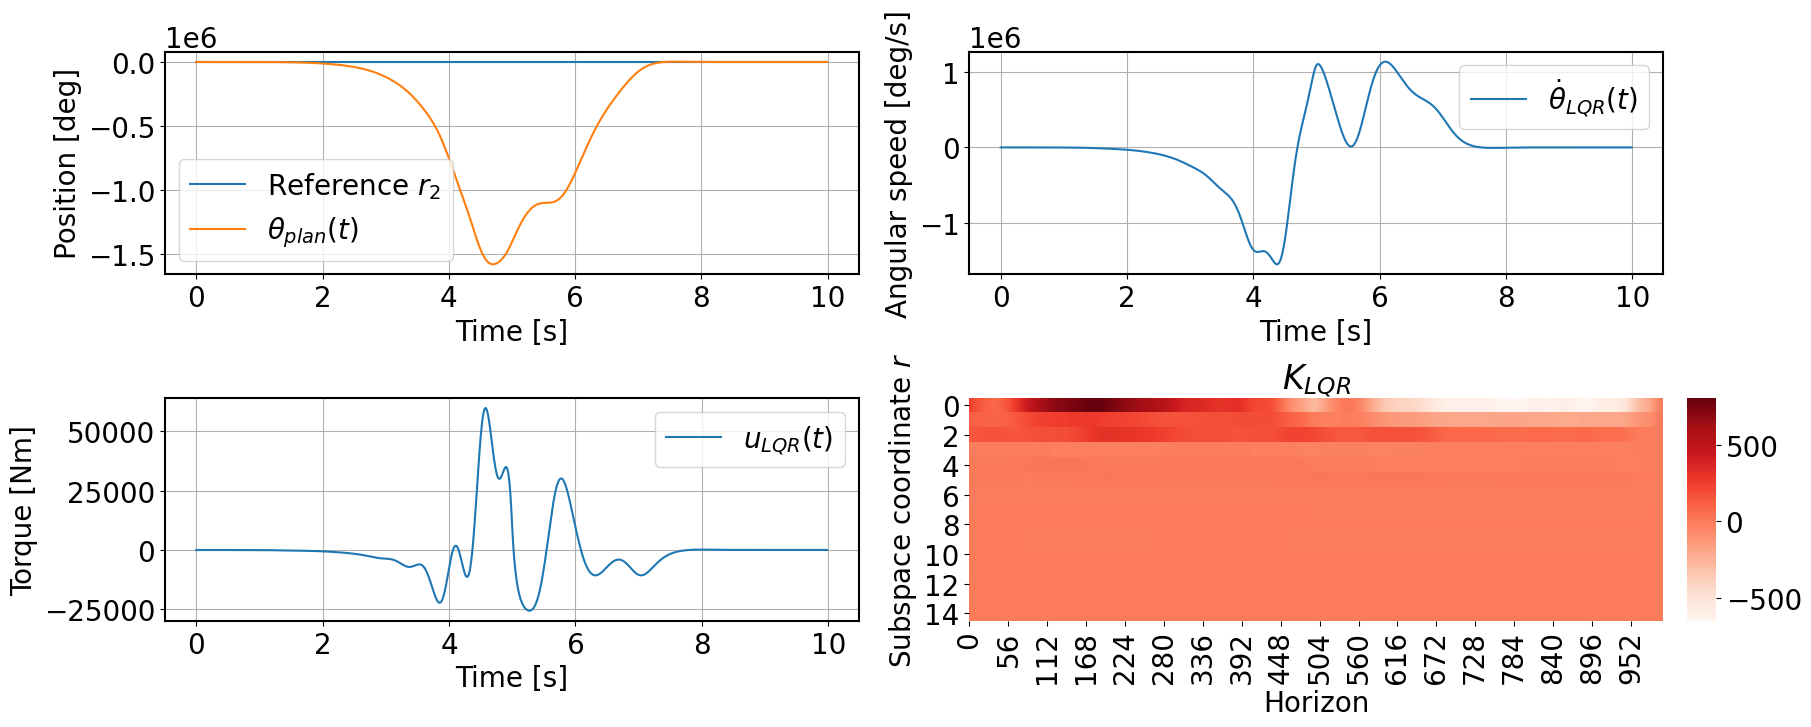

In [54]:
X0 = np.array([0,0])
Xc, Yc = np.zeros(shape=[model1.nb_S,model1.N]), np.zeros(shape=[model1.tau,model1.N])
Uc = np.empty(shape=[model1.N-1])
Ky = np.array(model1.LQR.K)[:,0,:]
Kx = Ky@pinv(model1.C)
t_interval = pend.dt

# Initial condition
Xc[:,0] = X0
N = np.eye(model1.tau) - pinv(model1.C) @ model1.C
Y0 = pinv(model1.C)@X0
Y0 = Y0 + N@(model1.Y[:,0] - Y0) # Nullspace projection into subspace 
Yc[:,0] = Y0

f = lambda theta, u : pend.dynamics(theta, u)

# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(model1.N-1):
    
    Uc[i] = model1.LQR.get_command(Yc[:,i],i)
    
    Xc[:,i+1]= RK4(f, Xc[:,i], Uc[i], t_interval, type='controller-step-by-step')
    Yc[:,i+1] = pinv(model1.C)@Xc[:,i+1]
    
# Evaluate LQR costs
cost_roll = model1.LQR_cost(model1.LQR_X.T,model1.LQR_U[0,:,0],reference[0,:])
cost_plan = model1.LQR_cost(Xc,Uc,reference[0,:])
print('Rollout cost is ',cost_roll/cost_plan*100,' [%] of planning cost')
    
# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(reference[0,:]), label="Reference $r_2$")
ax[0,0].plot(pend.T, rad2deg(Xc[0,:]), label=r"$\theta_{plan} (t)$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(Xc[1,:]), label=r"$\dot{\theta}_{LQR} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:model1.N-1], Uc, label='$u_{LQR}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')